In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pulp
import sys
import os
import importlib.util
import importlib
import gurobipy as gp

# モジュールを強制的に再ロード（古いキャッシュをクリア）
if 'code' in sys.modules:
    del sys.modules['code']
# サブモジュールも削除
for module_name in list(sys.modules.keys()):
    if module_name.startswith('code.'):
        del sys.modules[module_name]

current_dir = os.getcwd()
spec = importlib.util.spec_from_file_location("code", os.path.join(current_dir, "code", "__init__.py"))
code_module = importlib.util.module_from_spec(spec)
sys.modules["code"] = code_module
spec.loader.exec_module(code_module)

# サブモジュールも再ロード
importlib.reload(code_module)

# primal_multi_agentから直接インポート
from code.primal_multi_agent import (
    solve_mechanism_2agents,
    solve_mechanism_2agents_iterative,
    save_results_2agents,
    load_results_2agents
)

# utilsからグリッド生成関数をインポート
from code.utils import make_tensor_grid_2d

print("モジュールを再ロードしました")


モジュールを再ロードしました


In [3]:
home_license = os.path.expanduser('~/gurobi.lic')
os.environ['GRB_LICENSE_FILE'] = home_license

SOLVER = pulp.GUROBI(msg=True)


# ケース1: 2人2財


In [4]:
# ケース1: 両エージェントとも財a, 財bはBeta(1,1)
NX1, NY1 = 5, 5  # エージェント1のグリッドサイズ
NX2, NY2 = 5, 5  # エージェント2のグリッドサイズ
BETA_PARAMS_1 = [
    (1.0, 1.0),  # 財a
    (1.0, 1.0),  # 財b
]
BETA_PARAMS_2 = [
    (1.0, 1.0),  # 財a
    (1.0, 1.0),  # 財b
]

points1, weights1 = make_tensor_grid_2d(NX1, NY1, BETA_PARAMS_1)
points2, weights2 = make_tensor_grid_2d(NX2, NY2, BETA_PARAMS_2)
print(f"#types agent1 = {len(points1)}")
print(f"#types agent2 = {len(points2)}")
print(f"Total combinations = {len(points1) * len(points2)}")


#types agent1 = 25
#types agent2 = 25
Total combinations = 625


In [5]:
status1, obj_val1, u1_sol, u2_sol, p1_sol, p2_sol, n_iter1 = solve_mechanism_2agents_iterative(
    points1, weights1, (NX1, NY1),
    points2, weights2, (NX2, NY2),
    solver=SOLVER
)

print("LP status:", status1)
print("Optimal revenue:", obj_val1)
print(f"Number of iterations: {n_iter1}")

# 結果を保存
filepath_case1 = save_results_2agents(
    points1, weights1, points2, weights2,
    u1_sol, u2_sol, p1_sol, p2_sol,
    obj_val1, status1,
    grid_sizes1=(NX1, NY1),
    grid_sizes2=(NX2, NY2),
    n_iter=n_iter1,
    filename="results_kandori_case1.npz"
)


Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2749041
Academic license 2749041 - for non-commercial use only - registered to ko___@u.northwestern.edu
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (mac64[arm] - Darwin 25.1.0 25B78)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Academic license 2749041 - for non-commercial use only - registered to ko___@u.northwestern.edu
Optimize a model with 4000 rows, 3750 columns and 12000 nonzeros (Max)
Model fingerprint: 0x0b128f4e
Model has 3750 linear objective coefficients
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [2e-04, 2e-03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 500 rows and 500 columns
Presolve time: 0.02s
Presolved: 3500 rows, 3250 columns, 12600 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7128640e+00   4.410800e+00   0.00000

In [6]:
# 保存されたデータを読み込んで可視化
data1 = load_results_2agents("data/results_kandori_case1.npz")
print("Loaded data keys:", list(data1.keys()))
print("Agent 1 utility shape:", data1['u1_sol'].shape)
print("Agent 2 utility shape:", data1['u2_sol'].shape)
print("Agent 1 allocation shape:", data1['p1_sol'].shape)
print("Agent 2 allocation shape:", data1['p2_sol'].shape)

# データを取得
points1_arr = data1['points1']
points2_arr = data1['points2']
u1_sol = data1['u1_sol']
u2_sol = data1['u2_sol']
p1_sol = data1['p1_sol']
p2_sol = data1['p2_sol']
NX1, NY1 = data1['grid_sizes1']
NX2, NY2 = data1['grid_sizes2']


Loaded data keys: ['points1', 'weights1', 'points2', 'weights2', 'u1_sol', 'u2_sol', 'p1_sol', 'p2_sol', 'obj_val', 'J1', 'J2', 'grid_sizes1', 'grid_sizes2', 'n_iter', 'status', 'timestamp']
Agent 1 utility shape: (25, 25)
Agent 2 utility shape: (25, 25)
Agent 1 allocation shape: (2, 25, 25)
Agent 2 allocation shape: (2, 25, 25)


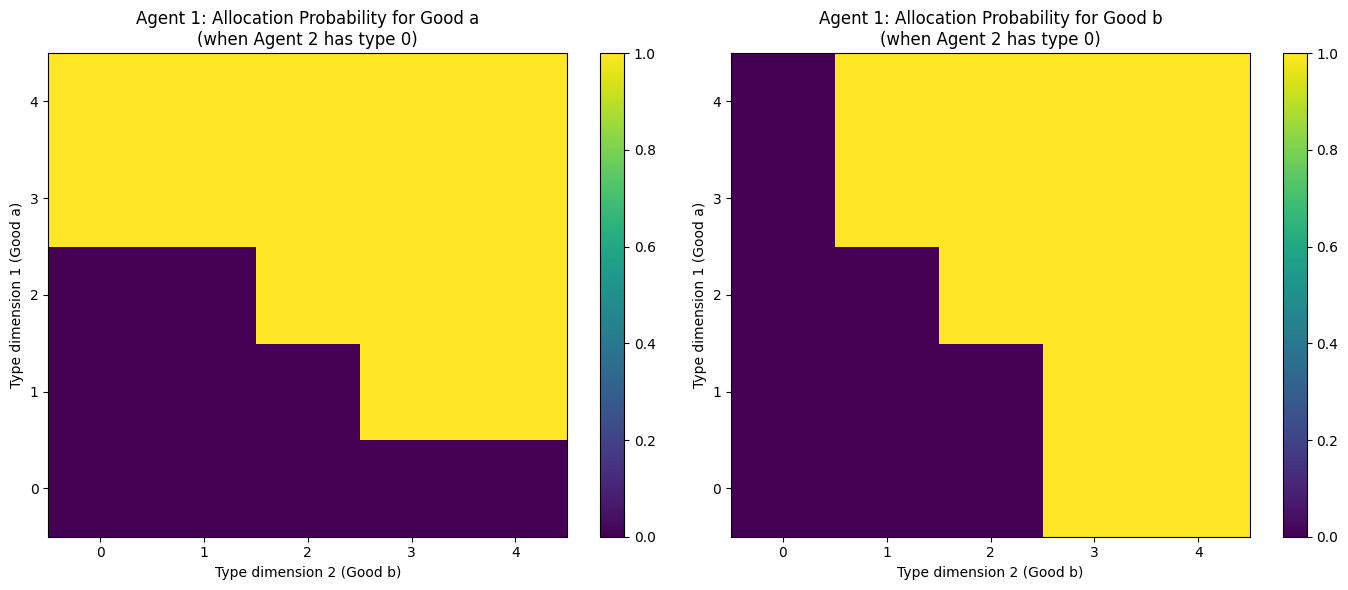

In [7]:
# 結果の可視化: エージェント1の配分確率（財a, 財b）
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# エージェント1が型j1で、エージェント2が型j2=0（最初の型）のときの配分確率
j2_example = 0
p1_a_slice = p1_sol[0, :, j2_example]  # 財aの配分確率
p1_b_slice = p1_sol[1, :, j2_example]  # 財bの配分確率

# エージェント1の型空間を2Dグリッドに再構成
p1_a_grid = p1_a_slice.reshape(NX1, NY1)
p1_b_grid = p1_b_slice.reshape(NX1, NY1)

# 財aの配分確率
im1 = axes[0].imshow(p1_a_grid, origin='lower', aspect='auto', cmap='viridis')
axes[0].set_title(f'Agent 1: Allocation Probability for Good a\n(when Agent 2 has type {j2_example})')
axes[0].set_xlabel('Type dimension 2 (Good b)')
axes[0].set_ylabel('Type dimension 1 (Good a)')
plt.colorbar(im1, ax=axes[0])

# 財bの配分確率
im2 = axes[1].imshow(p1_b_grid, origin='lower', aspect='auto', cmap='viridis')
axes[1].set_title(f'Agent 1: Allocation Probability for Good b\n(when Agent 2 has type {j2_example})')
axes[1].set_xlabel('Type dimension 2 (Good b)')
axes[1].set_ylabel('Type dimension 1 (Good a)')
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()


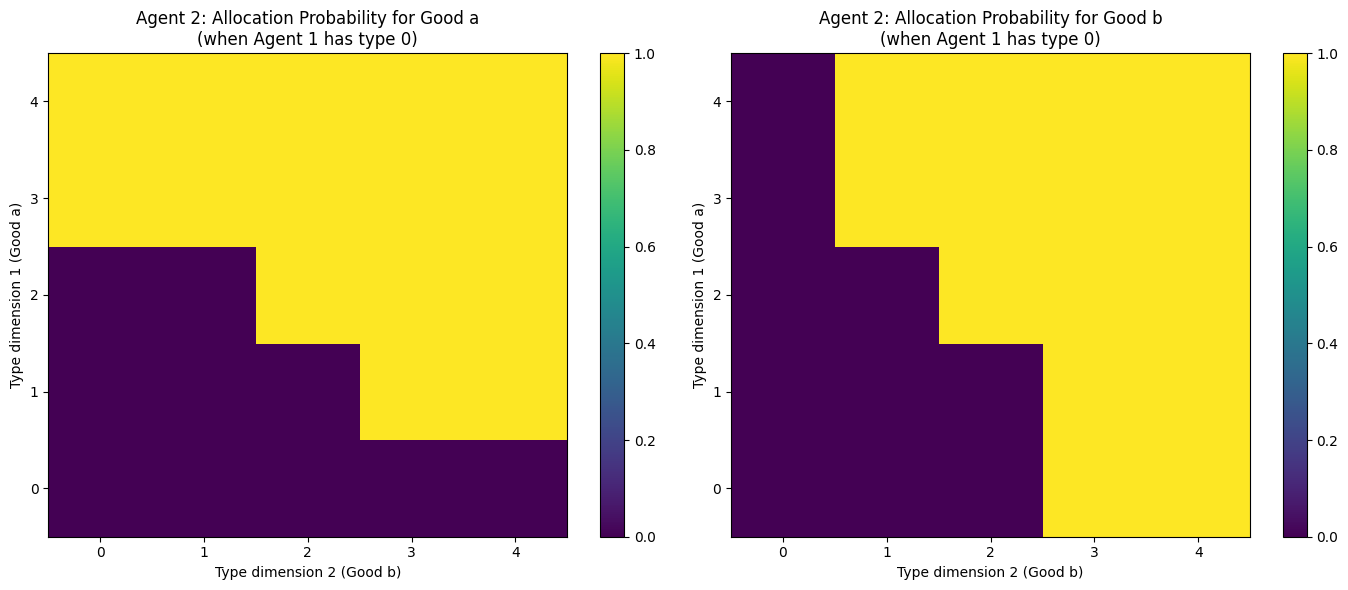

In [8]:
# 結果の可視化: エージェント2の配分確率（財a, 財b）
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# エージェント1が型j1=0（最初の型）で、エージェント2が型j2のときの配分確率
j1_example = 0
p2_a_slice = p2_sol[0, j1_example, :]  # 財aの配分確率
p2_b_slice = p2_sol[1, j1_example, :]  # 財bの配分確率

# エージェント2の型空間を2Dグリッドに再構成
p2_a_grid = p2_a_slice.reshape(NX2, NY2)
p2_b_grid = p2_b_slice.reshape(NX2, NY2)

# 財aの配分確率
im1 = axes[0].imshow(p2_a_grid, origin='lower', aspect='auto', cmap='viridis')
axes[0].set_title(f'Agent 2: Allocation Probability for Good a\n(when Agent 1 has type {j1_example})')
axes[0].set_xlabel('Type dimension 2 (Good b)')
axes[0].set_ylabel('Type dimension 1 (Good a)')
plt.colorbar(im1, ax=axes[0])

# 財bの配分確率
im2 = axes[1].imshow(p2_b_grid, origin='lower', aspect='auto', cmap='viridis')
axes[1].set_title(f'Agent 2: Allocation Probability for Good b\n(when Agent 1 has type {j1_example})')
axes[1].set_xlabel('Type dimension 2 (Good b)')
axes[1].set_ylabel('Type dimension 1 (Good a)')
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()


# ケース2: 異なる分布パラメータ


In [9]:
# ケース2: エージェント1はBeta(2,2)、エージェント2はBeta(1,1)
NX1_2, NY1_2 = 8, 8
NX2_2, NY2_2 = 8, 8
BETA_PARAMS_1_2 = [
    (2.0, 2.0),  # 財a
    (2.0, 2.0),  # 財b
]
BETA_PARAMS_2_2 = [
    (1.0, 1.0),  # 財a
    (1.0, 1.0),  # 財b
]

points1_2, weights1_2 = make_tensor_grid_2d(NX1_2, NY1_2, BETA_PARAMS_1_2)
points2_2, weights2_2 = make_tensor_grid_2d(NX2_2, NY2_2, BETA_PARAMS_2_2)
print(f"#types agent1 = {len(points1_2)}")
print(f"#types agent2 = {len(points2_2)}")
print(f"Total combinations = {len(points1_2) * len(points2_2)}")


#types agent1 = 64
#types agent2 = 64
Total combinations = 4096


In [10]:
status2, obj_val2, u1_sol_2, u2_sol_2, p1_sol_2, p2_sol_2, n_iter2 = solve_mechanism_2agents_iterative(
    points1_2, weights1_2, (NX1_2, NY1_2),
    points2_2, weights2_2, (NX2_2, NY2_2),
    solver=SOLVER
)

print("LP status:", status2)
print("Optimal revenue:", obj_val2)
print(f"Number of iterations: {n_iter2}")

# 結果を保存
filepath_case2 = save_results_2agents(
    points1_2, weights1_2, points2_2, weights2_2,
    u1_sol_2, u2_sol_2, p1_sol_2, p2_sol_2,
    obj_val2, status2,
    grid_sizes1=(NX1_2, NY1_2),
    grid_sizes2=(NX2_2, NY2_2),
    n_iter=n_iter2,
    filename="results_kandori_case2.npz"
)


Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (mac64[arm] - Darwin 25.1.0 25B78)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Academic license 2749041 - for non-commercial use only - registered to ko___@u.northwestern.edu
Optimize a model with 32672 rows, 28326 columns and 98016 nonzeros (Max)
Model has 28326 linear objective coefficients
Coefficient statistics:
  Matrix range     [1e-01, 1e+00]
  Objective range  [2e-06, 2e-03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
LP warm-start: use basis

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.2640000e+00   1.792000e+03   0.000000e+00      0s
   13969    2.4981986e+00   0.000000e+00   0.000000e+00      0s

Solved in 13969 iterations and 0.16 seconds (0.35 work units)
Optimal objective  2.498198596e+00
Gurobi status= 2
Iteration 1: 207614 violations found, added 207614 constraints
Gurobi Optimizer version 13.0.0 build v13.0.0rc

In [11]:
# 保存されたデータを読み込んで可視化
data2 = load_results_2agents("data/results_kandori_case2.npz")
print("Loaded data keys:", list(data2.keys()))

# データを取得
points1_arr_2 = data2['points1']
points2_arr_2 = data2['points2']
u1_sol_2 = data2['u1_sol']
u2_sol_2 = data2['u2_sol']
p1_sol_2 = data2['p1_sol']
p2_sol_2 = data2['p2_sol']
NX1_2, NY1_2 = data2['grid_sizes1']
NX2_2, NY2_2 = data2['grid_sizes2']


Loaded data keys: ['points1', 'weights1', 'points2', 'weights2', 'u1_sol', 'u2_sol', 'p1_sol', 'p2_sol', 'obj_val', 'J1', 'J2', 'grid_sizes1', 'grid_sizes2', 'n_iter', 'status', 'timestamp']


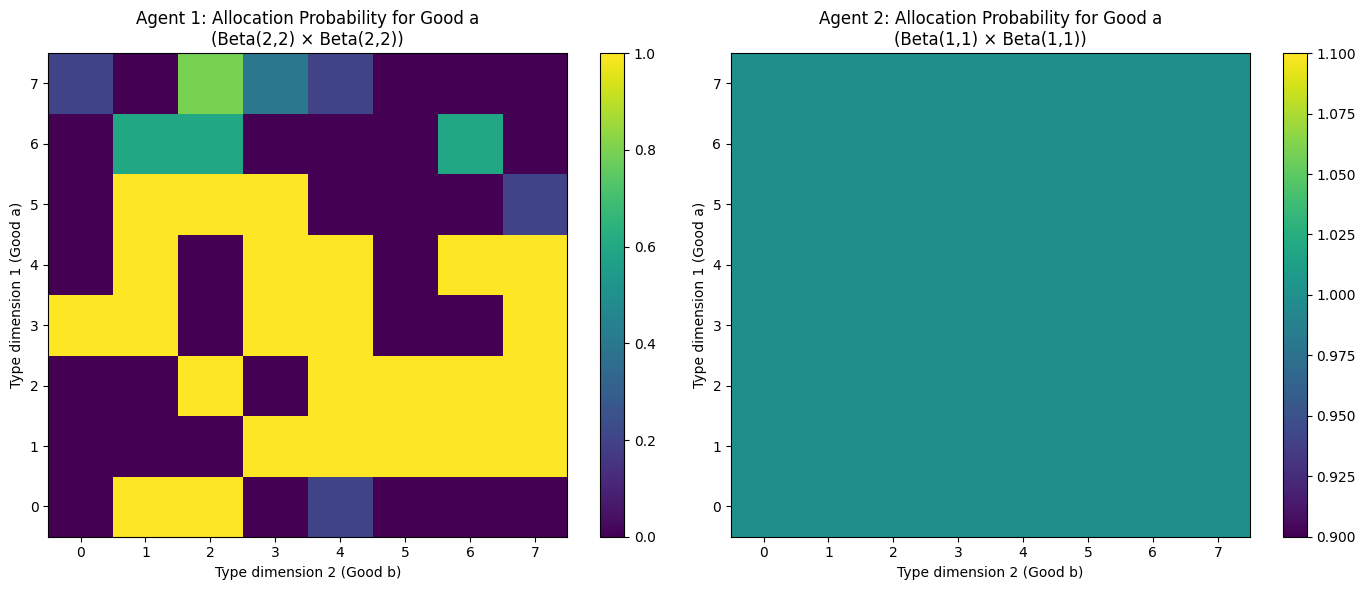

In [12]:
# ケース2の結果の可視化
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

j2_example = 0
p1_a_slice_2 = p1_sol_2[0, :, j2_example]
p1_a_grid_2 = p1_a_slice_2.reshape(NX1_2, NY1_2)

j1_example = 0
p2_a_slice_2 = p2_sol_2[0, j1_example, :]
p2_a_grid_2 = p2_a_slice_2.reshape(NX2_2, NY2_2)

im1 = axes[0].imshow(p1_a_grid_2, origin='lower', aspect='auto', cmap='viridis')
axes[0].set_title(f'Agent 1: Allocation Probability for Good a\n(Beta(2,2) × Beta(2,2))')
axes[0].set_xlabel('Type dimension 2 (Good b)')
axes[0].set_ylabel('Type dimension 1 (Good a)')
plt.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(p2_a_grid_2, origin='lower', aspect='auto', cmap='viridis')
axes[1].set_title(f'Agent 2: Allocation Probability for Good a\n(Beta(1,1) × Beta(1,1))')
axes[1].set_xlabel('Type dimension 2 (Good b)')
axes[1].set_ylabel('Type dimension 1 (Good a)')
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()


# 結果の比較と分析


In [13]:
# ケース1とケース2の比較（保存されたデータから読み込み）
data1 = load_results_2agents("data/results_kandori_case1.npz")
data2 = load_results_2agents("data/results_kandori_case2.npz")

print("=== ケース1 ===")
print(f"Optimal revenue: {data1['obj_val']:.6f}")
if 'n_iter' in data1:
    print(f"Number of iterations: {data1['n_iter']}")
print(f"Grid size: Agent1 {data1['grid_sizes1']}, Agent2 {data1['grid_sizes2']}")

print("\n=== ケース2 ===")
print(f"Optimal revenue: {data2['obj_val']:.6f}")
if 'n_iter' in data2:
    print(f"Number of iterations: {data2['n_iter']}")
print(f"Grid size: Agent1 {data2['grid_sizes1']}, Agent2 {data2['grid_sizes2']}")

# 効用の統計
print("\n=== エージェント1の効用統計（ケース1） ===")
print(f"Mean: {np.mean(data1['u1_sol']):.6f}")
print(f"Max: {np.max(data1['u1_sol']):.6f}")
print(f"Min: {np.min(data1['u1_sol']):.6f}")

print("\n=== エージェント2の効用統計（ケース1） ===")
print(f"Mean: {np.mean(data1['u2_sol']):.6f}")
print(f"Max: {np.max(data1['u2_sol']):.6f}")
print(f"Min: {np.min(data1['u2_sol']):.6f}")

print("\n=== エージェント1の効用統計（ケース2） ===")
print(f"Mean: {np.mean(data2['u1_sol']):.6f}")
print(f"Max: {np.max(data2['u1_sol']):.6f}")
print(f"Min: {np.min(data2['u1_sol']):.6f}")

print("\n=== エージェント2の効用統計（ケース2） ===")
print(f"Mean: {np.mean(data2['u2_sol']):.6f}")
print(f"Max: {np.max(data2['u2_sol']):.6f}")
print(f"Min: {np.min(data2['u2_sol']):.6f}")


=== ケース1 ===
Optimal revenue: 1.264000
Number of iterations: 1
Grid size: Agent1 (np.int32(5), np.int32(5)), Agent2 (np.int32(5), np.int32(5))

=== ケース2 ===
Optimal revenue: 0.300316
Number of iterations: 2
Grid size: Agent1 (np.int32(8), np.int32(8)), Agent2 (np.int32(8), np.int32(8))

=== エージェント1の効用統計（ケース1） ===
Mean: 0.176000
Max: 0.800000
Min: 0.000000

=== エージェント2の効用統計（ケース1） ===
Mean: 0.176000
Max: 0.800000
Min: 0.000000

=== エージェント1の効用統計（ケース2） ===
Mean: 0.593872
Max: 1.000000
Min: 0.000000

=== エージェント2の効用統計（ケース2） ===
Mean: 0.281586
Max: 1.000000
Min: 0.000000


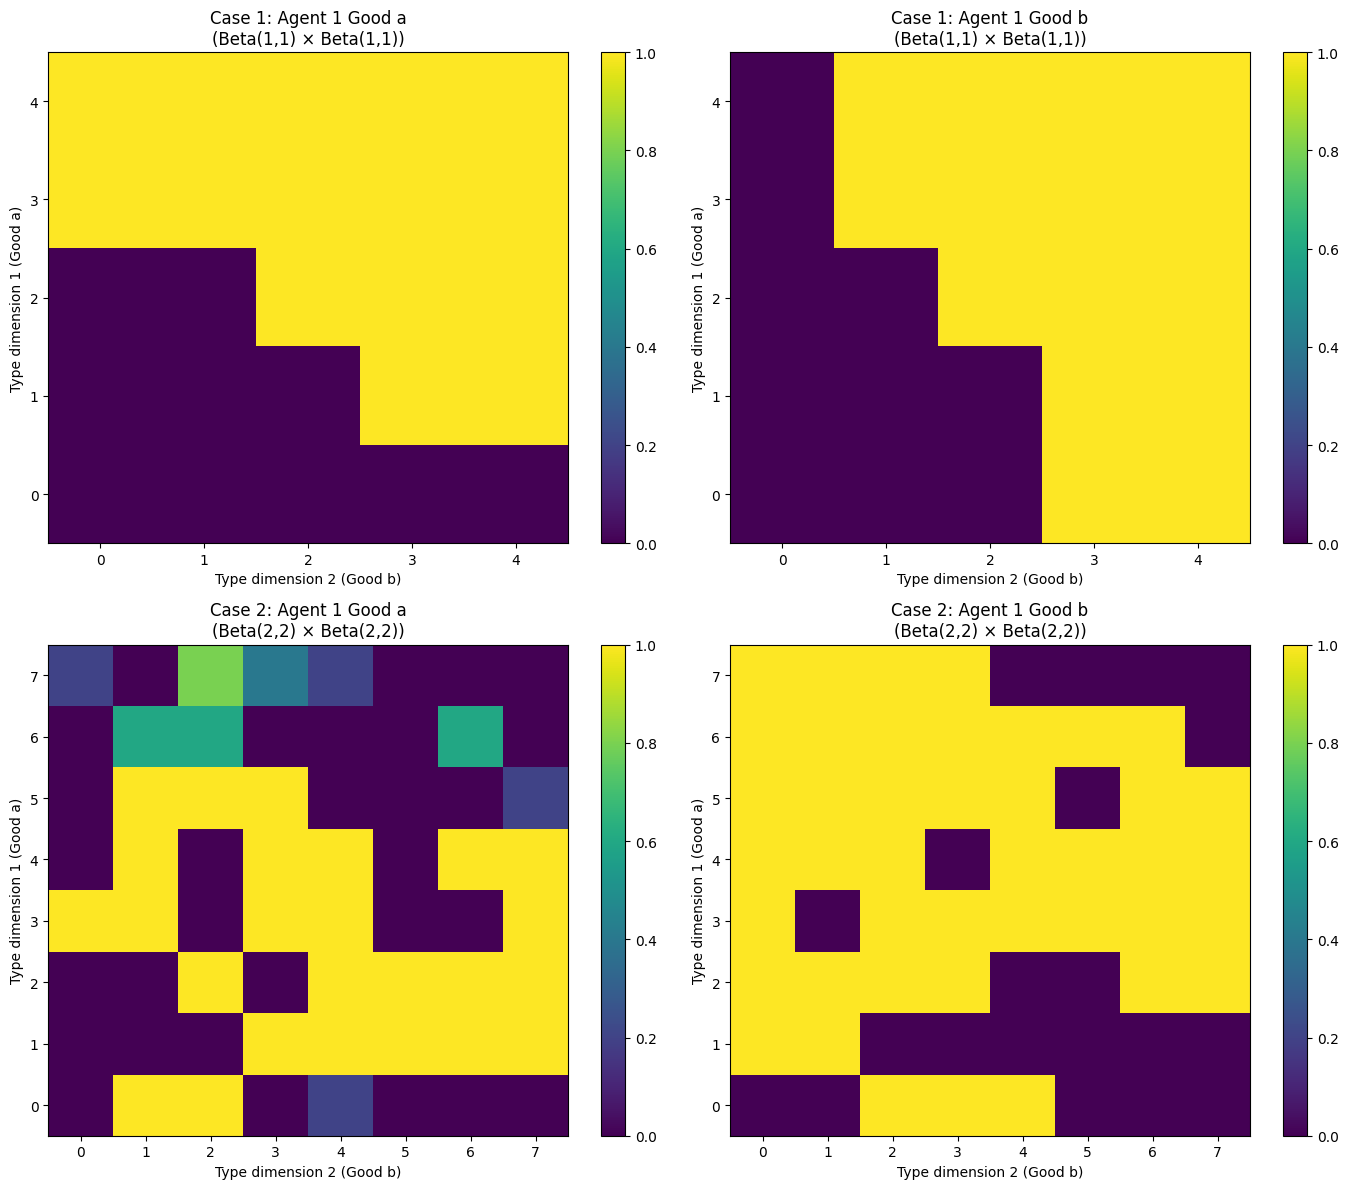

In [14]:
# エージェント1の配分確率の比較（エージェント2の型を固定）
data1 = load_results_2agents("data/results_kandori_case1.npz")
data2 = load_results_2agents("data/results_kandori_case2.npz")

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# ケース1: エージェント2が型j2=0のとき
j2_example = 0
p1_a_case1 = data1['p1_sol'][0, :, j2_example].reshape(data1['grid_sizes1'])
p1_b_case1 = data1['p1_sol'][1, :, j2_example].reshape(data1['grid_sizes1'])

# ケース2: エージェント2が型j2=0のとき
p1_a_case2 = data2['p1_sol'][0, :, j2_example].reshape(data2['grid_sizes1'])
p1_b_case2 = data2['p1_sol'][1, :, j2_example].reshape(data2['grid_sizes1'])

# ケース1の可視化
im1 = axes[0, 0].imshow(p1_a_case1, origin='lower', aspect='auto', cmap='viridis')
axes[0, 0].set_title('Case 1: Agent 1 Good a\n(Beta(1,1) × Beta(1,1))')
axes[0, 0].set_xlabel('Type dimension 2 (Good b)')
axes[0, 0].set_ylabel('Type dimension 1 (Good a)')
plt.colorbar(im1, ax=axes[0, 0])

im2 = axes[0, 1].imshow(p1_b_case1, origin='lower', aspect='auto', cmap='viridis')
axes[0, 1].set_title('Case 1: Agent 1 Good b\n(Beta(1,1) × Beta(1,1))')
axes[0, 1].set_xlabel('Type dimension 2 (Good b)')
axes[0, 1].set_ylabel('Type dimension 1 (Good a)')
plt.colorbar(im2, ax=axes[0, 1])

# ケース2の可視化
im3 = axes[1, 0].imshow(p1_a_case2, origin='lower', aspect='auto', cmap='viridis')
axes[1, 0].set_title('Case 2: Agent 1 Good a\n(Beta(2,2) × Beta(2,2))')
axes[1, 0].set_xlabel('Type dimension 2 (Good b)')
axes[1, 0].set_ylabel('Type dimension 1 (Good a)')
plt.colorbar(im3, ax=axes[1, 0])

im4 = axes[1, 1].imshow(p1_b_case2, origin='lower', aspect='auto', cmap='viridis')
axes[1, 1].set_title('Case 2: Agent 1 Good b\n(Beta(2,2) × Beta(2,2))')
axes[1, 1].set_xlabel('Type dimension 2 (Good b)')
axes[1, 1].set_ylabel('Type dimension 1 (Good a)')
plt.colorbar(im4, ax=axes[1, 1])

plt.tight_layout()
plt.show()
